# Reading XRF data

In [1]:
from XRDXRFutils import DataXRF,resample

from numpy import arange,linspace
from matplotlib.pyplot import plot,subplots,xlim,ylim,hlines,vlines,xlabel,ylabel,imshow,legend,vlines,savefig,semilogy

from scipy.interpolate import interp1d
from numpy import concatenate,append,array,diff,trapz

from multiprocessing import Pool
import h5py

In [2]:
data = DataXRF()

In [3]:
path = '/home/zdenek/storage/dataXRDXRF/Giulia_XRF/'
data.calibrate_from_file('/home/zdenek/storage/dataXRDXRF/Giulia_XRF/calibration.ini')

In [4]:
data.calibration.x,data.calibration.y

(array([1388.,  726.,  868.,  254.]), array([20.21 , 10.551, 12.61 ,  3.69 ]))

In [5]:
data.calibration.fce,data.calibration.opt

(<function XRDXRFutils.data.DataXRF.fce_calibration(x, a, b, c)>,
 array([6.32924784e-08, 1.44629700e-02, 1.29409598e-02]))

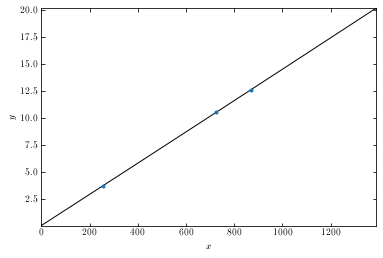

In [6]:
data.calibration.plot()

In [7]:
%%time
data.read(path + 'edfs/')

Reading XRF data
Done
CPU times: user 2.36 s, sys: 3.92 s, total: 6.28 s
Wall time: 24 s


In [9]:
%%time
data.save_h5(path + 'xrf.h5')

Saving: /home/zdenek/storage/dataXRDXRF/Giulia_XRF/xrf.h5
CPU times: user 617 ms, sys: 2.64 s, total: 3.25 s
Wall time: 15.5 s


In [16]:
%%time
path = '/home/zdenek/storage/dataXRDXRF/Giulia_XRF/'
data.load_h5(path + 'xrf.h5')
data.shape,data.metadata,data.calibration.metadata

Loading: /home/zdenek/storage/dataXRDXRF/Giulia_XRF/xrf.h5
CPU times: user 4.75 ms, sys: 1.04 s, total: 1.05 s
Wall time: 1.04 s


((418, 418, 2048),
 {'path': '/home/zdenek/storage/dataXRDXRF/Giulia_XRF/edfs/'},
 {'filename': '/home/zdenek/storage/dataXRDXRF/Giulia_XRF/calibration.ini'})

In [7]:
with h5py.File(path + 'xrf.h5') as f:
    for k,v in f['data'].attrs.items():
        print(k,v)

In [8]:
data.metadata,data.calibration.metadata,data.x.max()

({'path': '/home/zdenek/storage/dataXRDXRF/Giulia_XRF/edfs/'},
 {'filename': '/home/zdenek/storage/dataXRDXRF/Giulia_XRF/calibration.ini'},
 29.883849323664318)

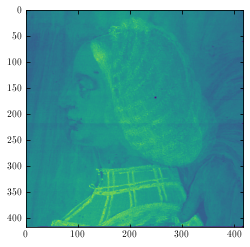

In [9]:
imshow(data.data.sum(-1)[::-1])

Text(0, 0.5, 'counts')

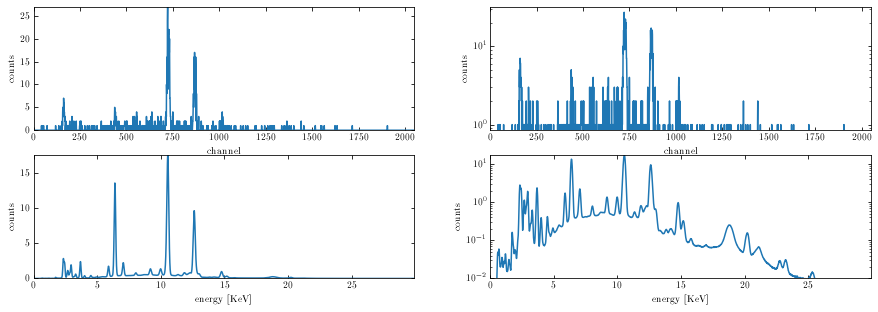

In [11]:
fig,ax = subplots(2,2,figsize=(15,5))

y = data.data[100,101]

ax[0,0].plot(y)
ax[0,0].set_xlim(0,2048)
ax[0,0].set_ylim(0,y.max())
ax[0,0].set_xlabel('channel')
ax[0,0].set_ylabel('counts')

ax[0,1].semilogy(y)
ax[0,1].set_xlim(0,2048)
ax[0,1].set_xlabel('channel')
ax[0,1].set_ylabel('counts')

y = data.data.mean(0).mean(0)
x = data.x

ax[1,0].plot(x,y)
ax[1,0].set_xlim(0,x.max())
ax[1,0].set_ylim(0,y.max())
ax[1,0].set_xlabel('energy [KeV]')
ax[1,0].set_ylabel('counts')

ax[1,1].semilogy(x,y)
ax[1,1].set_xlim(0,x.max())
ax[1,1].set_ylim(1e-2,y.max())
ax[1,1].set_xlabel('energy [KeV]')
ax[1,1].set_ylabel('counts')

In [31]:
%%time
new_data = data.resample(nbins=256)

CPU times: user 30.8 s, sys: 13.1 s, total: 43.9 s
Wall time: 1min 4s


In [32]:
new_data.shape

(418, 418, 256)

In [33]:
new_data.save_h5(path + 'xrf_256.h5')

Saving: /home/zdenek/storage/dataXRDXRF/Giulia_XRF/xrf_256.h5


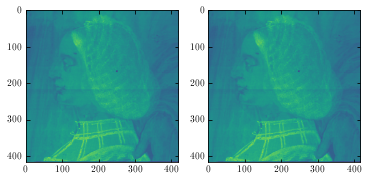

In [26]:
fig,ax = subplots(1,2)

ax[0].imshow(data.data.sum(-1)[::-1])
ax[1].imshow(new_data.data.sum(-1)[::-1])

(0.0, 30.0)

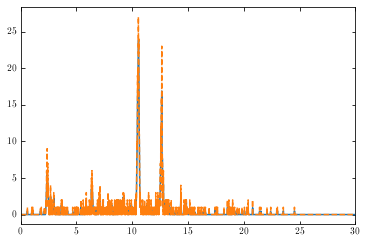

In [28]:
%matplotlib inline
plot(new_data.x,new_data.data[100,120]/2)
plot(data.x,data.data[100,120],'--')
xlim(0,30)

1004.3531111925095 2048 0.0146484375
1004.3531111925104 1024 0.029296875
1004.353111192512 512 0.05859375
1004.3531111925104 256 0.1171875
CPU times: user 700 ms, sys: 1.62 ms, total: 701 ms
Wall time: 698 ms


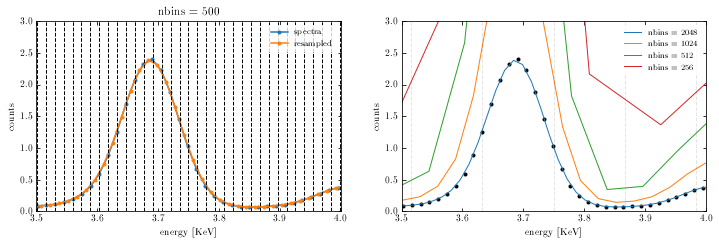

In [13]:
%%time
x = data.x
y = data.data.mean(0).mean(0)
n = 2048

ix,iy = resample(x,y,nbins=n)

fig,ax = subplots(1,2,figsize=(12,3.5))

ax[0].plot(x,y,'.-',label='spectra')
b = ix[1] - ix[0]
ax[0].plot(ix,iy,'.-',label='resampled')

ax[0].vlines((ix[1:] + ix[:-1]) * 0.5,0,3,'k',ls='--',lw=1)

ax[0].set_xlim(3.5,4)
ax[0].set_ylim(0,3)
ax[0].set_xlabel('energy [KeV]')
ax[0].set_ylabel('counts')
ax[0].set_title('nbins = 500')
ax[0].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')

ax[1].plot(x,y,'k.')

for n in [2048,1024,512,256]:
    ix,iy = resample(x,y,n)
    b = ix[1] - ix[0]
    print(sum(iy),n,b)
    
    ax[1].plot(ix,iy,'-',lw=1,label=r'nbins = %s'%n)
    #ax[1].plot(ix,iy,'-',lw=1,label=r'nbins = %s'%n)
    
ax[1].vlines((ix[1:] + ix[:-1]) * 0.5,0,3,'k',ls='--',lw=1,alpha=0.1)
    
#xlim(5.6,6.2)
ax[1].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')
ax[1].set_xlim(3.5,4)
ax[1].set_ylim(0,3)
ax[1].set_xlabel('energy [KeV]')
ax[1].set_ylabel('counts')

savefig('doc/resampling.png')

1004.3531111925104 4096 0.00732421875
1004.3531111925095 2048 0.0146484375
1004.3531111925104 1024 0.029296875
1004.353111192512 512 0.05859375
1004.3531111925104 256 0.1171875
14.609159488756289 1004.3531111925106
CPU times: user 630 ms, sys: 2.7 ms, total: 633 ms
Wall time: 629 ms


Text(0, 0.5, 'counts')

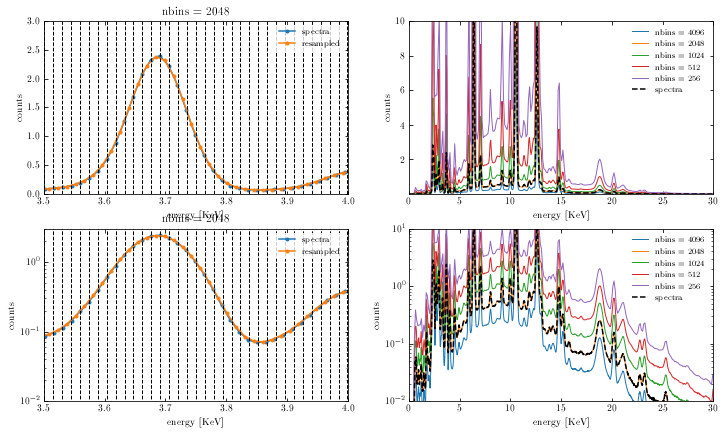

In [20]:
%%time
x = data.x
y = data.data.mean(0).mean(0)
n = 2048

ix,iy = resample(x,y,nbins=n,bounds=(0,30))

fig,ax = subplots(2,2,figsize=(12,7))

ax[0,0].plot(x,y,'.-',label='spectra')
b = ix[1] - ix[0]
ax[0,0].plot(ix,iy,'.-',label='resampled')
ax[0,0].vlines((ix[1:] + ix[:-1]) * 0.5,0,3,'k',ls='--',lw=1)

ax[0,0].set_xlim(3.5,4)
ax[0,0].set_ylim(0,3)
ax[0,0].set_xlabel('energy [KeV]')
ax[0,0].set_ylabel('counts')
ax[0,0].set_title('nbins = %d'%n)
ax[0,0].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')

ax[1,0].semilogy(x,y,'.-',label='spectra')
b = ix[1] - ix[0]
ax[1,0].semilogy(ix,iy,'.-',label='resampled')
ax[1,0].vlines((ix[1:] + ix[:-1]) * 0.5,0,3,'k',ls='--',lw=1)

ax[1,0].set_xlim(3.5,4)
ax[1,0].set_ylim(1e-2,3)
ax[1,0].set_xlabel('energy [KeV]')
ax[1,0].set_ylabel('counts')
ax[1,0].set_title('nbins = %d'%n)
ax[1,0].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')

for n in [4096,2048,1024,512,256]:
    ix,iy = resample(x,y,n,bounds=(0,30))
    b = ix[1] - ix[0]
    
    print(sum(iy),n,b)
    
    ax[0,1].plot(ix,iy,'-',lw=1,label=r'nbins = %s'%n)
    ax[1,1].semilogy(ix,iy,'-',lw=1,label=r'nbins = %s'%n)
    
ax[0,1].plot(x,y,'k--',label='spectra')
ax[1,1].semilogy(x,y,'k--',label='spectra')
    
print(trapz(y,x),sum(y))

ax[0,1].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')
ax[0,1].set_xlim(0,30)
ax[0,1].set_ylim(1e-2,1e1)
ax[0,1].set_xlabel('energy [KeV]')
ax[0,1].set_ylabel('counts')

ax[1,1].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')
ax[1,1].set_xlim(0,30)
ax[1,1].set_ylim(1e-2,1e1)
ax[1,1].set_xlabel('energy [KeV]')
ax[1,1].set_ylabel('counts')

1065.9999999999998 4096 0.00732421875 1065.9999999999998
1066.0000000000007 2048 0.0146484375 1066.0000000000007
1066.0000000000014 1024 0.029296875 1066.0000000000014
1066.0000000000002 512 0.05859375 1066.0000000000002
1066.000000000001 256 0.1171875 1066.000000000001
15.510228519680142 1066.0
CPU times: user 258 ms, sys: 186 µs, total: 258 ms
Wall time: 255 ms


Text(0, 0.5, 'counts')

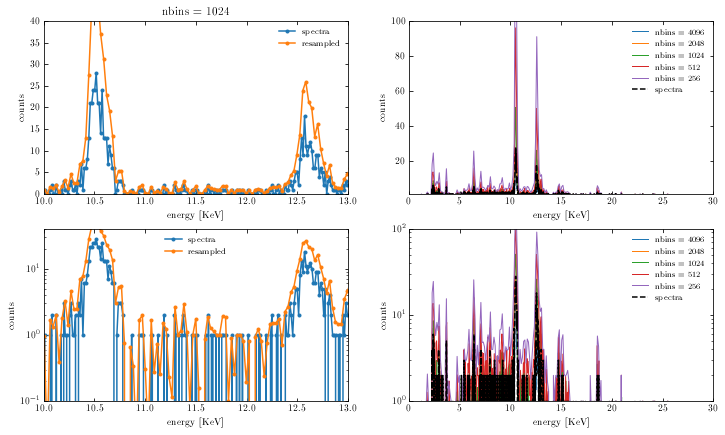

In [21]:
%%time
x = data.x
y = data.data[50,50]
n = 2048
n = 1024

ix,iy = resample(x,y,nbins=n,bounds=(0,30))

fig,ax = subplots(2,2,figsize=(12,7))

ax[0,0].plot(x,y,'.-',label='spectra')
b = ix[1] - ix[0]
ax[0,0].plot(ix,iy,'.-',label='resampled')
#ax[0,0].vlines((ix[1:] + ix[:-1]) * 0.5,0,3,'k',ls='--',lw=1)

ax[0,0].set_xlim(10,13)
ax[0,0].set_ylim(0,40)
ax[0,0].set_xlabel('energy [KeV]')
ax[0,0].set_ylabel('counts')
ax[0,0].set_title('nbins = %d'%n)
ax[0,0].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')

ax[1,0].semilogy(x,y,'.-',label='spectra')
b = ix[1] - ix[0]
ax[1,0].semilogy(ix,iy,'.-',label='resampled')
#ax[1,0].vlines((ix[1:] + ix[:-1]) * 0.5,0,3,'k',ls='--',lw=1)

ax[1,0].set_xlim(10,13)
ax[1,0].set_ylim(1e-1,40)
ax[1,0].set_xlabel('energy [KeV]')
ax[1,0].set_ylabel('counts')
ax[1,0].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')

for n in [4096,2048,1024,512,256]:
    ix,iy = resample(x,y,n,bounds=(0,30))
    b = ix[1] - ix[0]
    
    scale = sum(y)/sum(iy)
    print(sum(iy),n,b,sum(iy))
    
    ax[0,1].plot(ix,iy,'-',lw=1,label=r'nbins = %s'%n)
    ax[1,1].semilogy(ix,iy,'-',lw=1,label=r'nbins = %s'%n)
    
ax[0,1].plot(x,y,'k--',label='spectra')
ax[1,1].semilogy(x,y,'k--',label='spectra')
    
print(trapz(y,x),sum(y))

ax[0,1].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')
ax[0,1].set_xlim(0,30)
ax[0,1].set_ylim(1,1e2)
ax[0,1].set_xlabel('energy [KeV]')
ax[0,1].set_ylabel('counts')

ax[1,1].legend(frameon=True,facecolor='w',framealpha=0.8,edgecolor='w')
ax[1,1].set_xlim(0,30)
ax[1,1].set_ylim(1,1e2)
ax[1,1].set_xlabel('energy [KeV]')
ax[1,1].set_ylabel('counts')